**Aluno:**

* Marcos Madruga (mcmap@cesar.school)

# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [31]:
! pip install Pillow

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [33]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [34]:
!ls MNIST

processed  raw


In [35]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [36]:
x_train = x_train.float()

x_train = x_train / 255.

if False:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

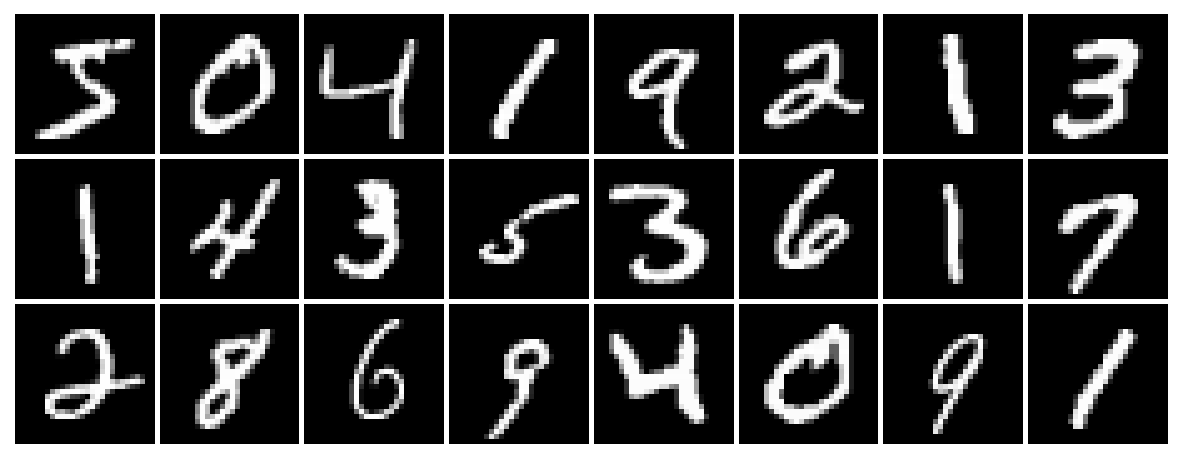

In [37]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


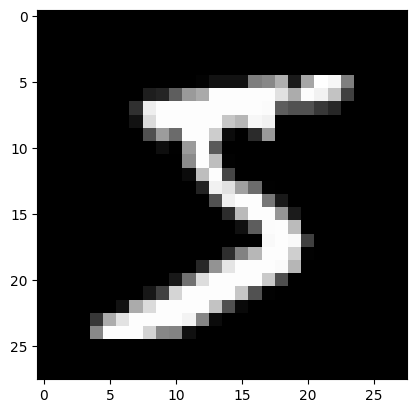

In [38]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [39]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [40]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.1025, -0.2118,  0.1625, -0.1829,  0.0759,  0.1498, -0.0891, -0.1538,
          0.0914, -0.0662],
        [-0.0959, -0.3693, -0.0161,  0.0268,  0.0155,  0.0021,  0.1678, -0.2165,
          0.1925, -0.0349],
        [ 0.0748,  0.0568, -0.1790, -0.0406,  0.1195,  0.2847,  0.0064, -0.2258,
          0.1978, -0.0607],
        [-0.0845,  0.0009,  0.0912, -0.1881, -0.1168,  0.0012,  0.1018, -0.1739,
          0.0025, -0.0313],
        [-0.2065, -0.0064,  0.5139, -0.3289, -0.0307, -0.1667,  0.2437, -0.2041,
         -0.0383, -0.1487]], grad_fn=<AddmmBackward0>)

In [41]:
xin.shape

torch.Size([5, 784])

## Treinamento

### Inicialização dos parâmetros

In [42]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [43]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-0usee3ue
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-0usee3ue
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [44]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3262, grad_fn=<NllLossBackward0>)

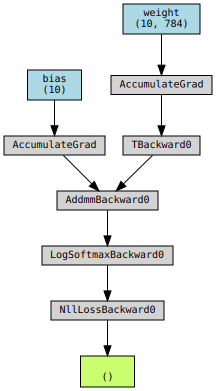

In [45]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [46]:
import numpy
losses = []
zs = []

#epochs = 1 ##

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [47]:
print('Final loss:', loss.item())

Final loss: 0.3940192461013794


### Visualizando gráfico de perda durante o treinamento

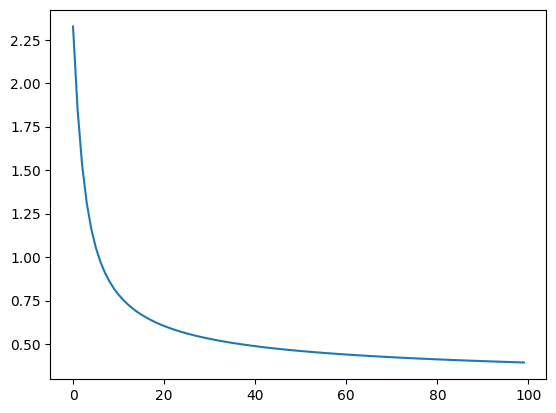

In [48]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [49]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.8943833333333333


### Matriz de confusão com dados de treinamento e teste

In [50]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,5680,1,60,34,12,104,48,47,33,49
1,0,6506,78,41,35,72,29,96,170,39
2,24,33,5101,158,44,49,73,102,90,44
3,21,30,96,5288,5,240,5,22,187,101
4,14,6,128,7,5304,88,50,83,26,226
5,45,49,16,259,7,4409,86,11,170,40
6,57,11,132,46,71,110,5565,3,46,5
7,6,15,122,82,17,34,2,5655,39,202
8,68,80,183,140,47,218,58,19,4971,59


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


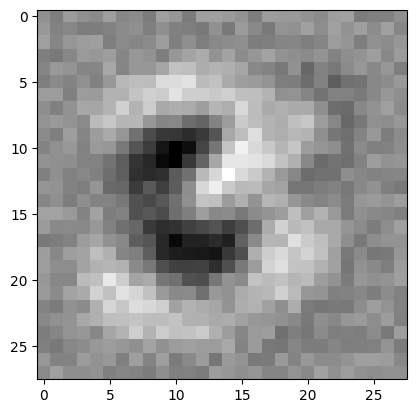

In [51]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

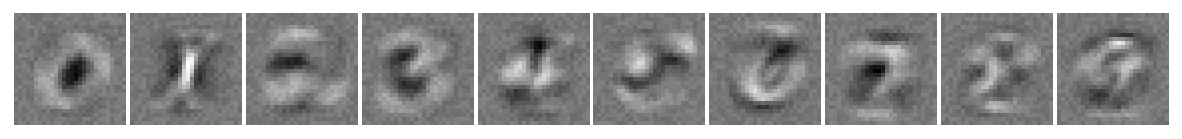

In [52]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [53]:
# resposta 1

import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f'Época {i+1} \tPerda: {loss.data:.8f} \tAcurácia: {accuracy}')

Época 1 	Perda: 0.39322457 	Acurácia: 0.8943833333333333
Época 2 	Perda: 0.39244205 	Acurácia: 0.8945166666666666
Época 3 	Perda: 0.39167142 	Acurácia: 0.8947
Época 4 	Perda: 0.39091215 	Acurácia: 0.8948833333333334
Época 5 	Perda: 0.39016417 	Acurácia: 0.8950333333333333
Época 6 	Perda: 0.38942713 	Acurácia: 0.8950833333333333
Época 7 	Perda: 0.38870075 	Acurácia: 0.8952833333333333
Época 8 	Perda: 0.38798475 	Acurácia: 0.8954833333333333
Época 9 	Perda: 0.38727897 	Acurácia: 0.8955833333333333
Época 10 	Perda: 0.38658318 	Acurácia: 0.8957833333333334
Época 11 	Perda: 0.38589695 	Acurácia: 0.8958666666666667
Época 12 	Perda: 0.38522029 	Acurácia: 0.89605
Época 13 	Perda: 0.38455275 	Acurácia: 0.8961333333333333
Época 14 	Perda: 0.38389435 	Acurácia: 0.8963166666666667
Época 15 	Perda: 0.38324469 	Acurácia: 0.8964333333333333
Época 16 	Perda: 0.38260373 	Acurácia: 0.8965666666666666
Época 17 	Perda: 0.38197121 	Acurácia: 0.8967333333333334
Época 18 	Perda: 0.38134694 	Acurácia: 0.89693

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

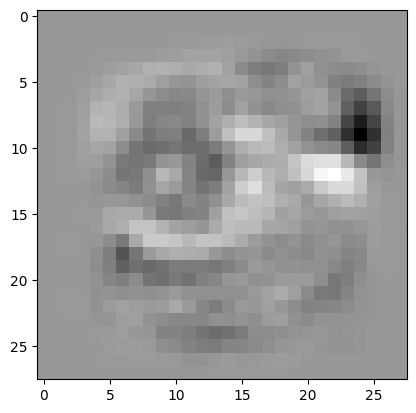

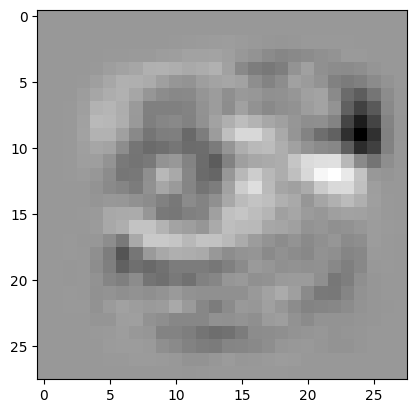

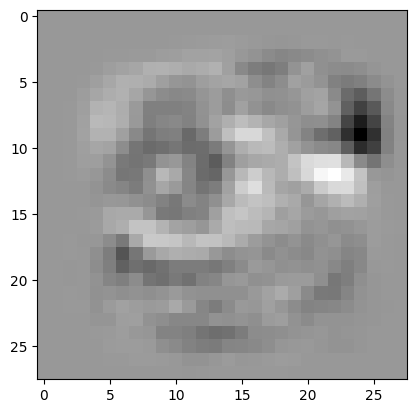

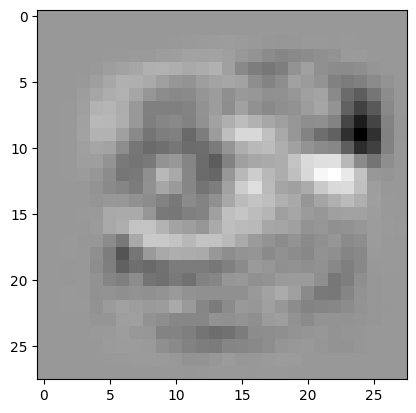

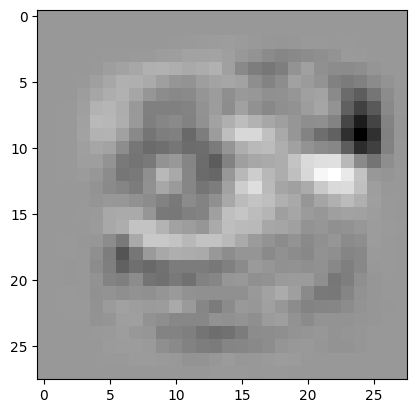

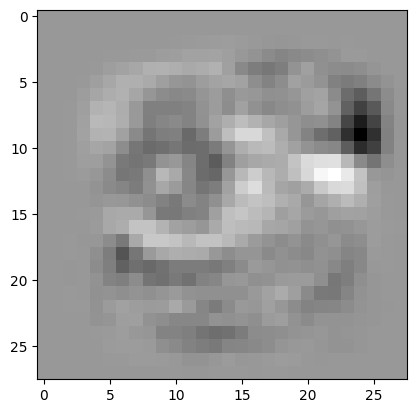

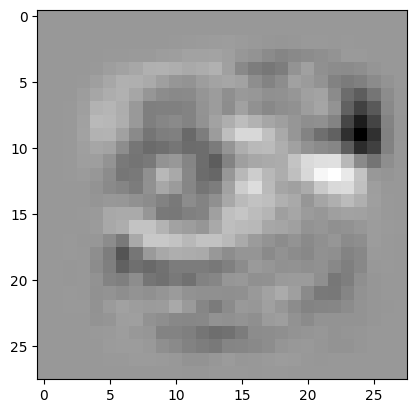

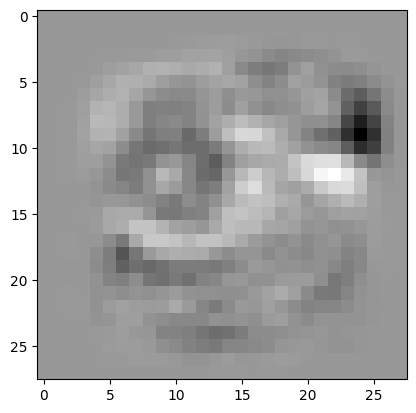

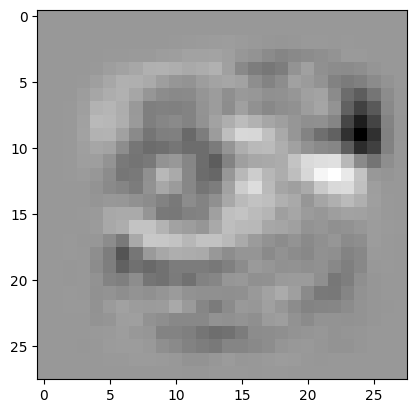

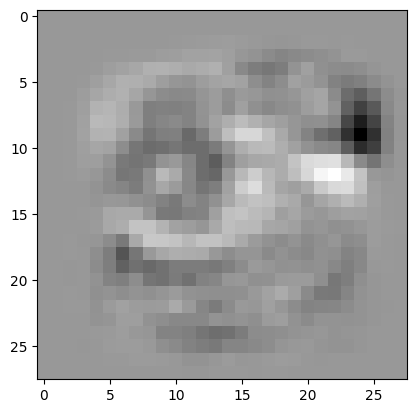

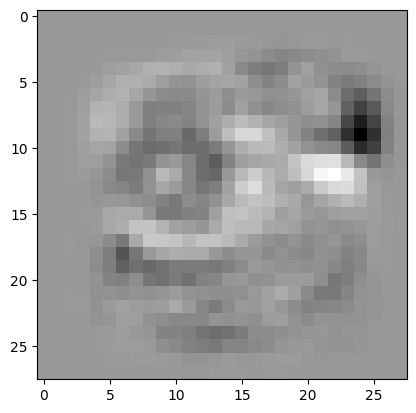

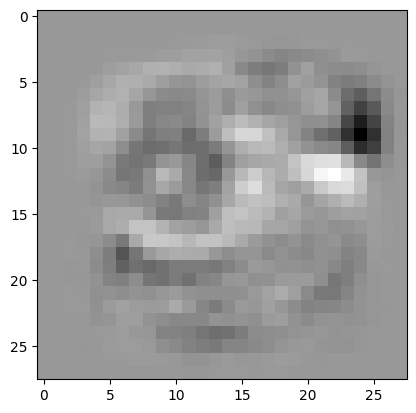

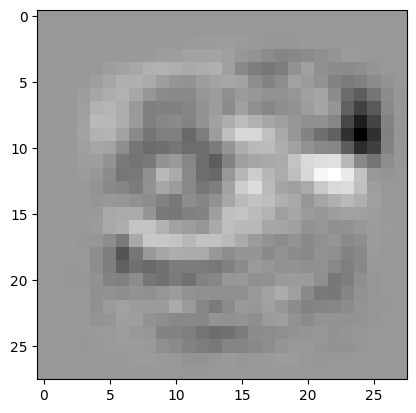

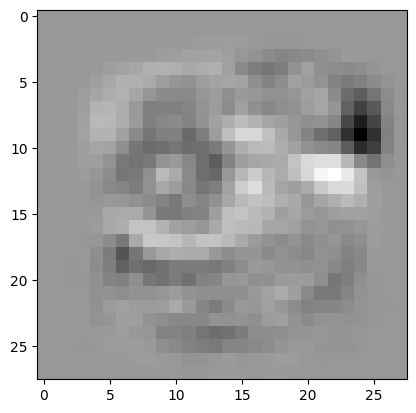

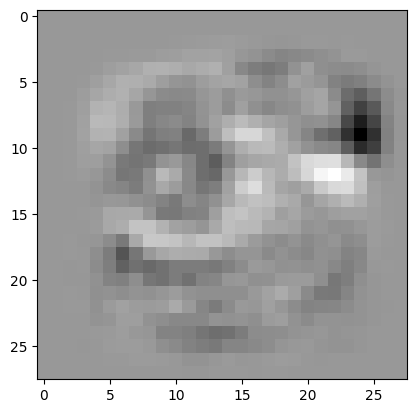

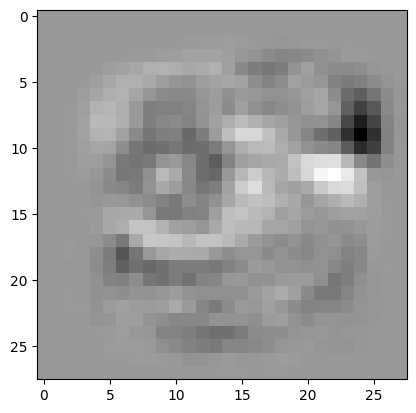

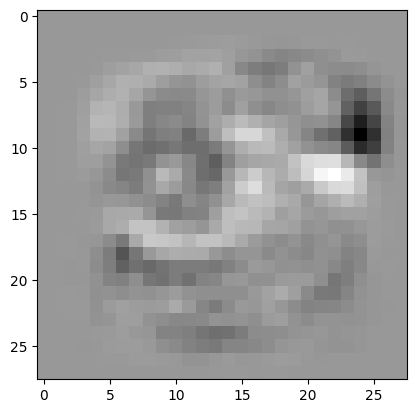

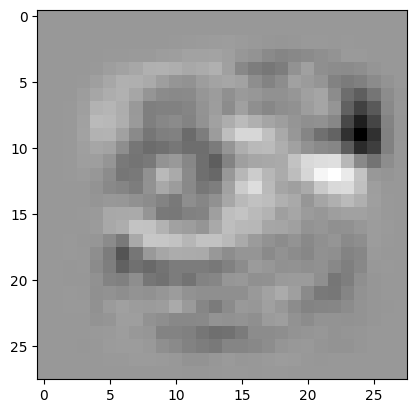

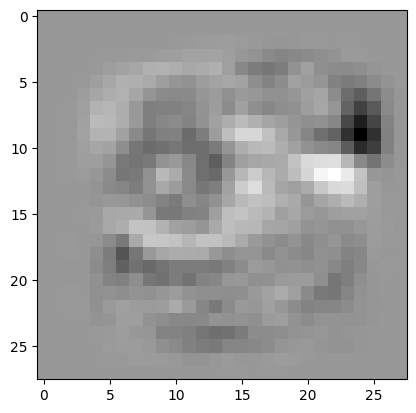

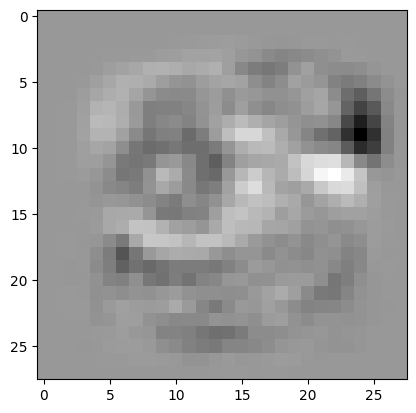

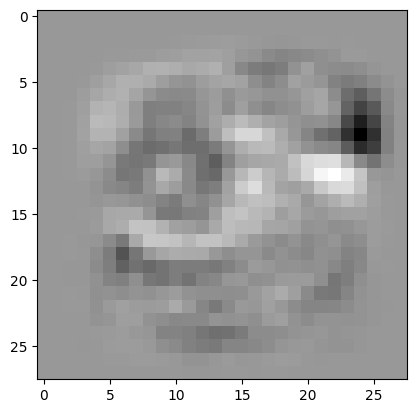

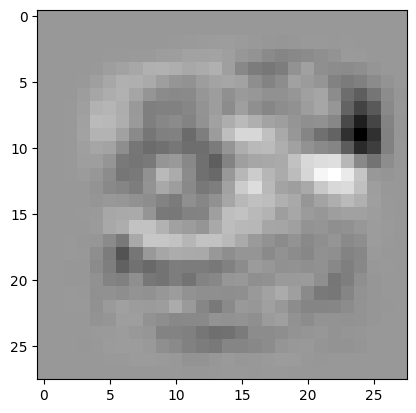

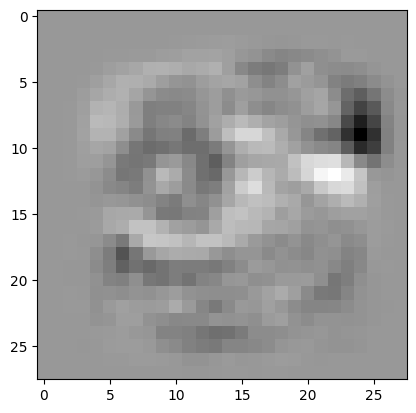

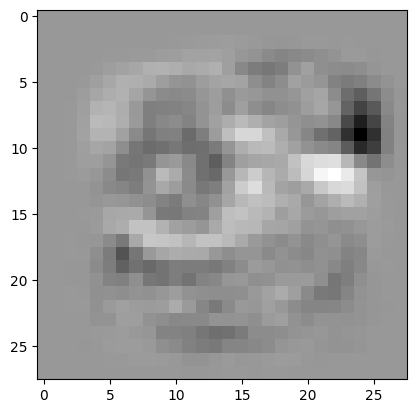

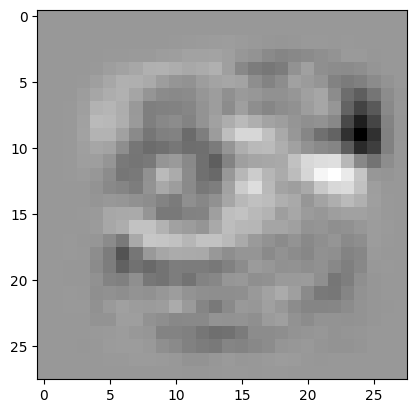

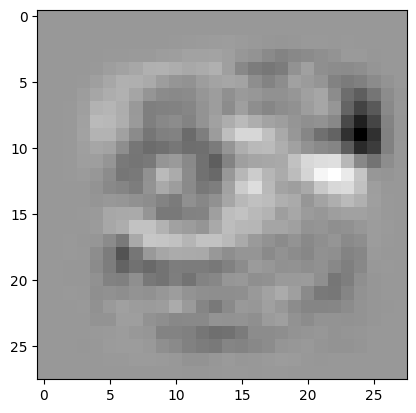

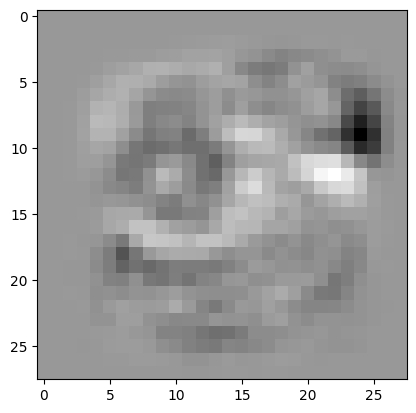

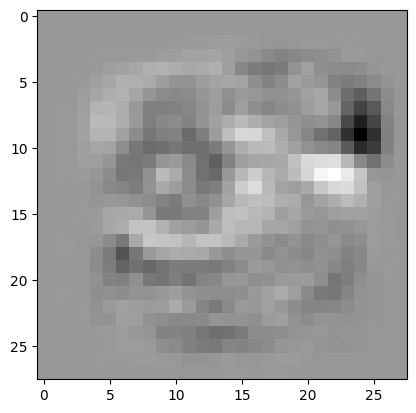

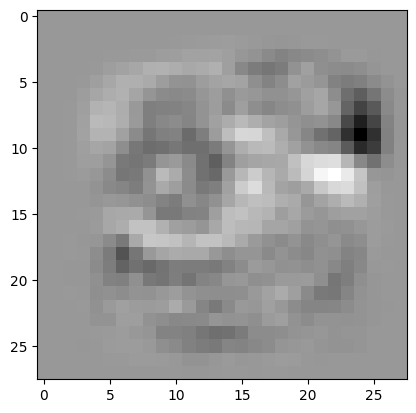

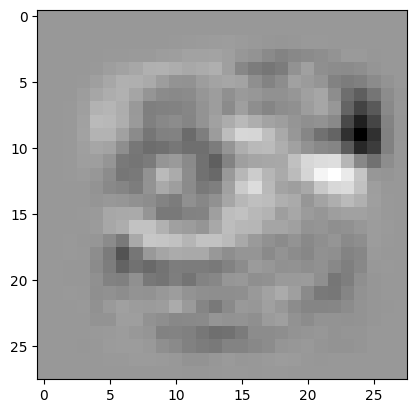

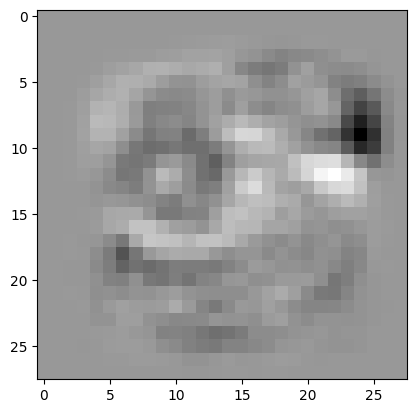

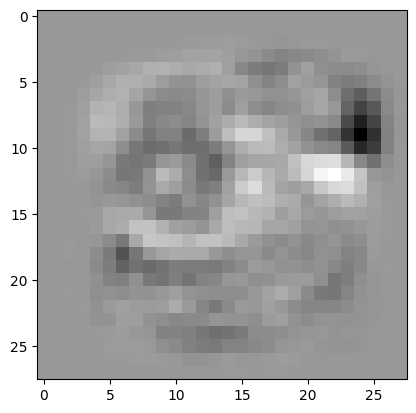

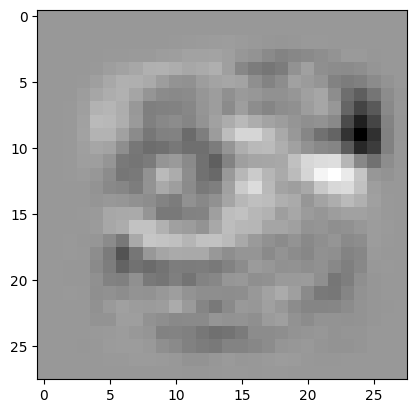

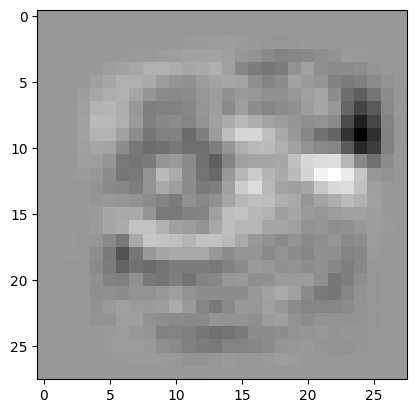

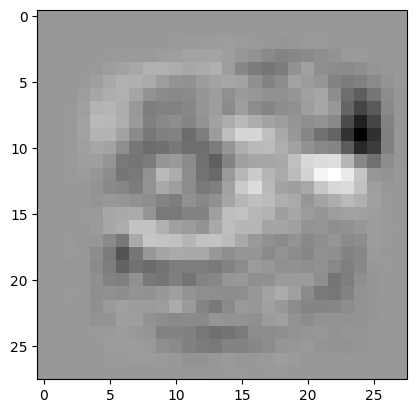

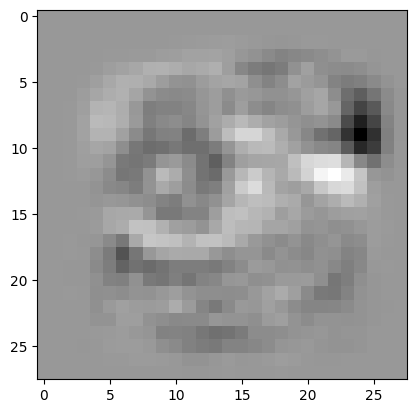

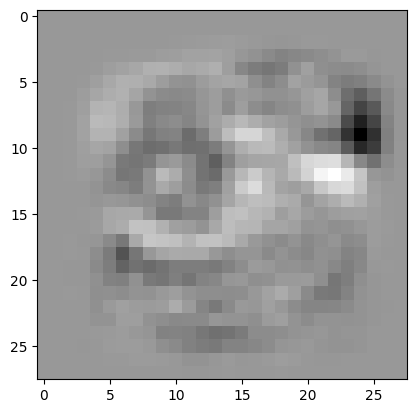

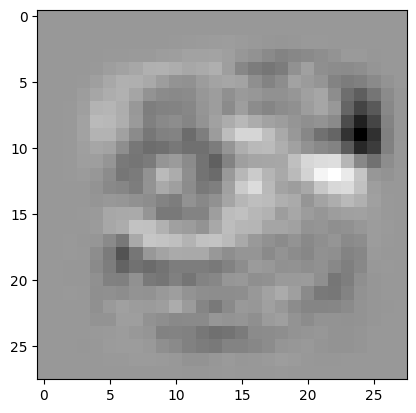

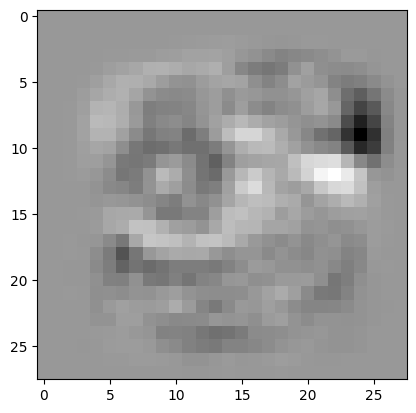

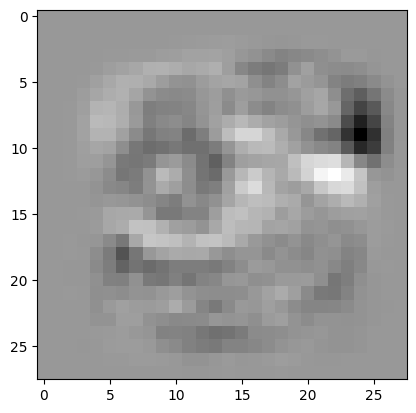

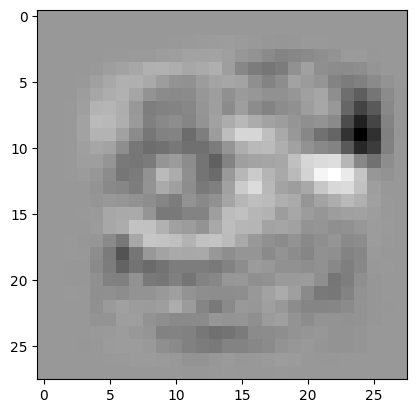

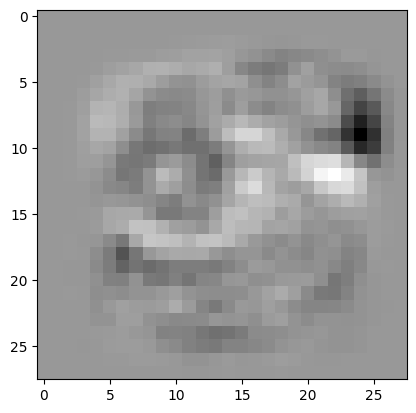

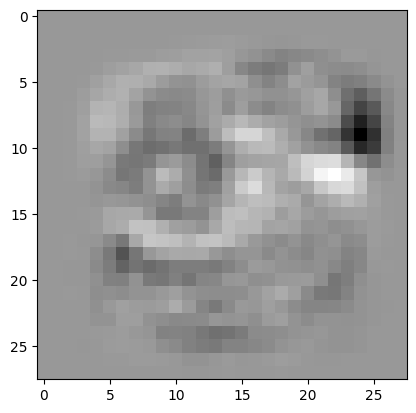

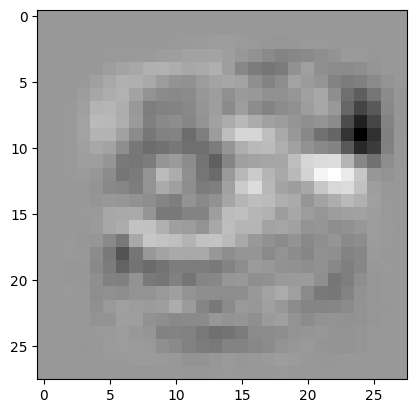

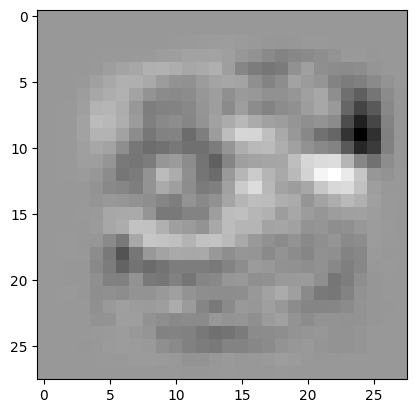

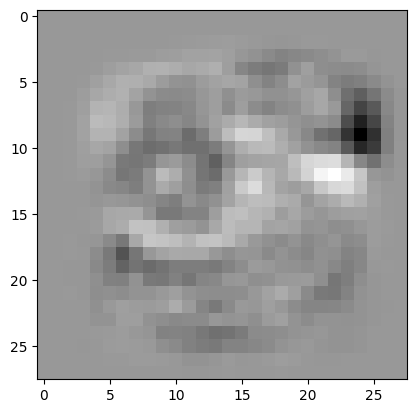

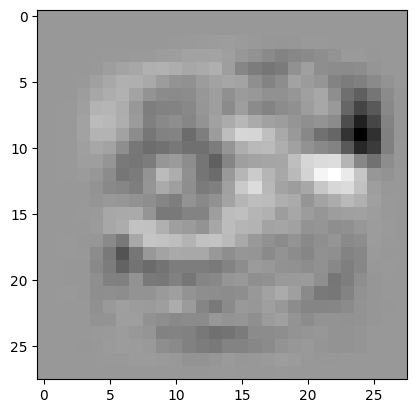

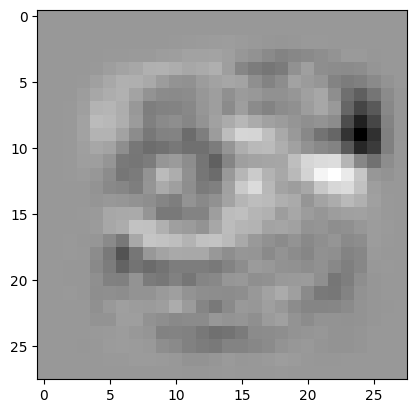

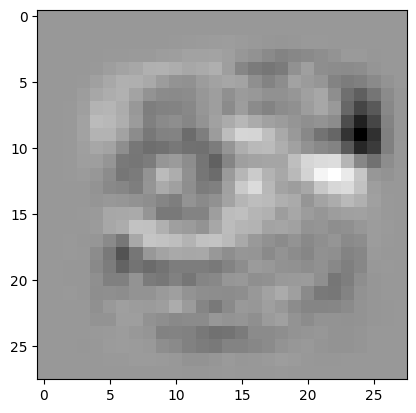

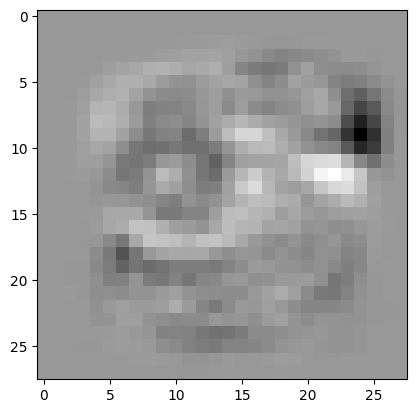

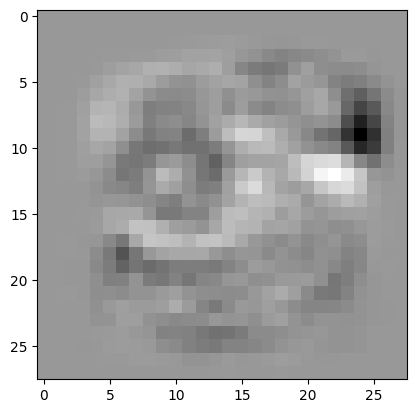

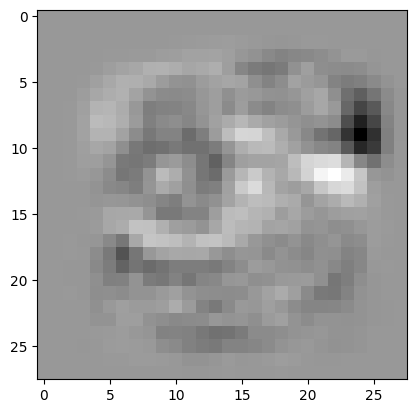

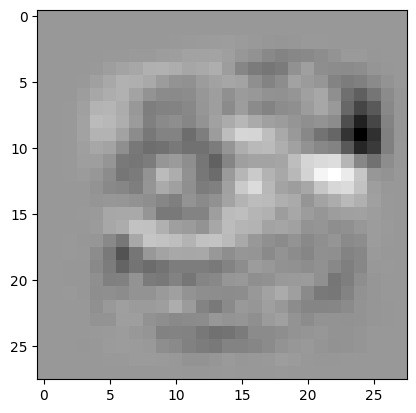

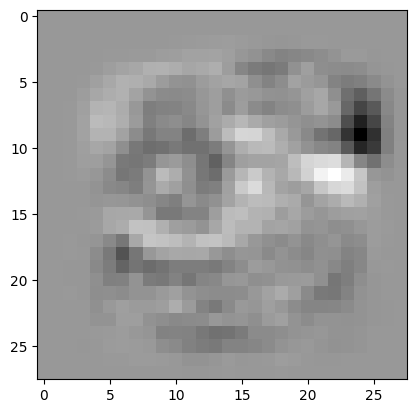

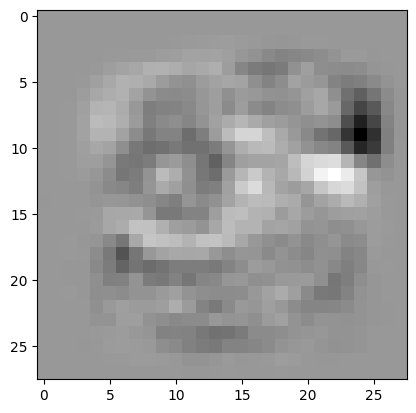

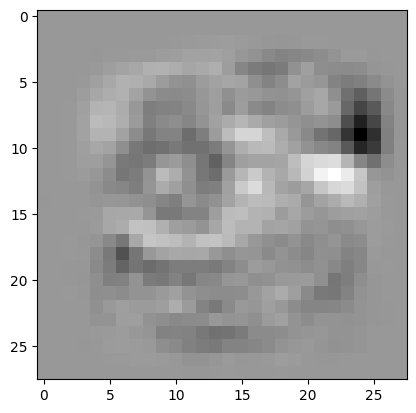

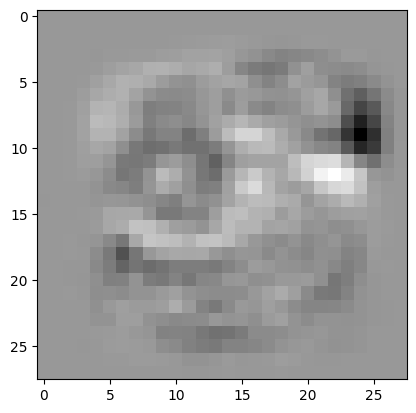

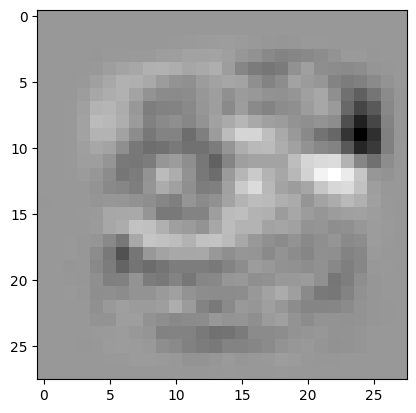

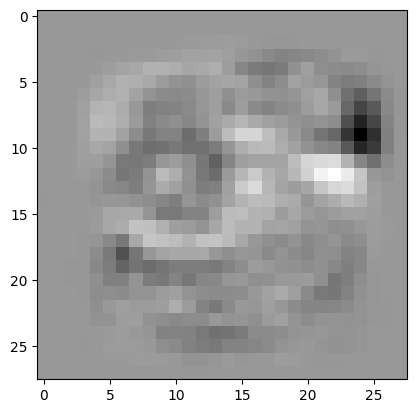

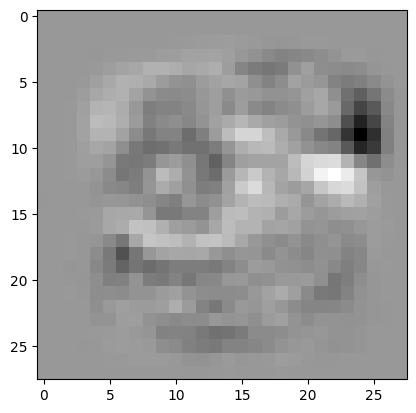

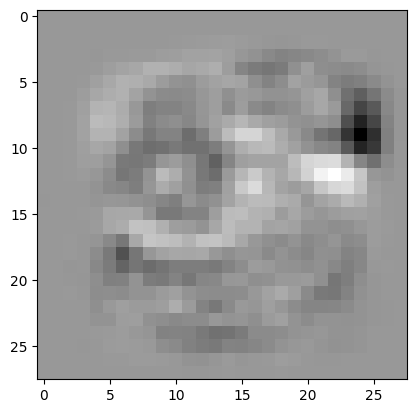

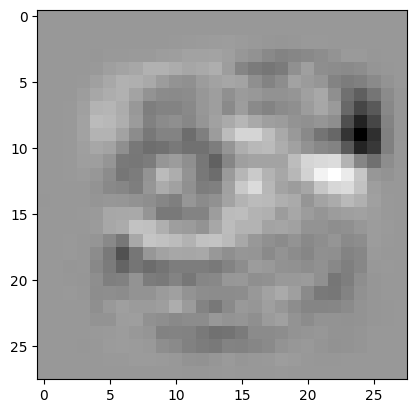

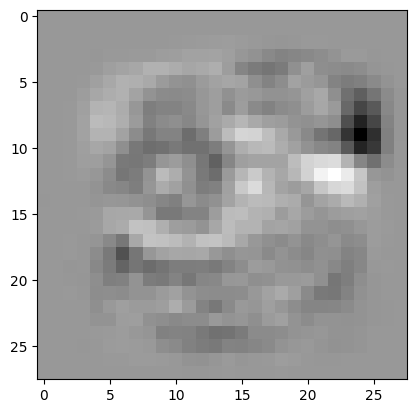

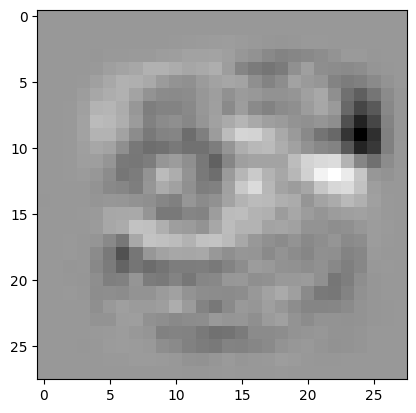

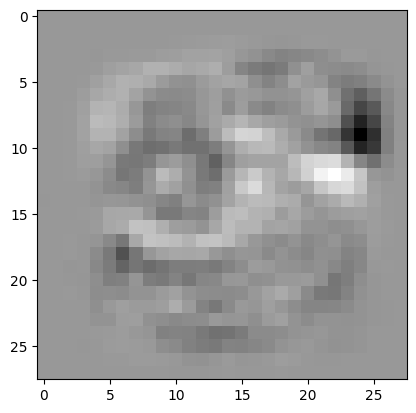

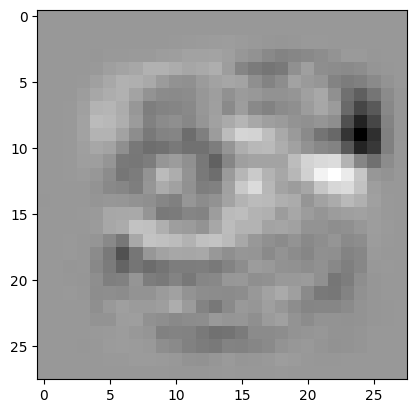

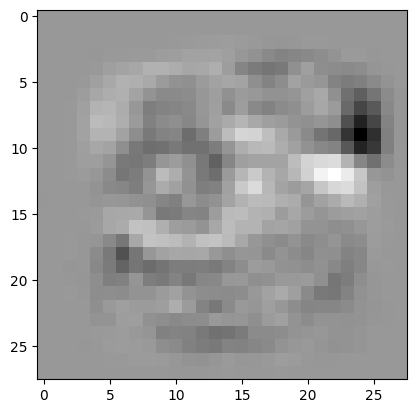

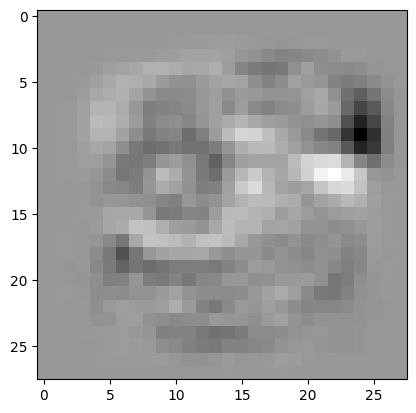

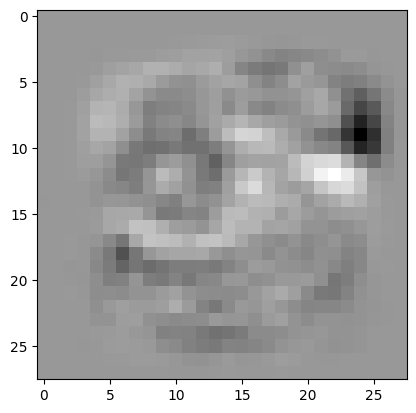

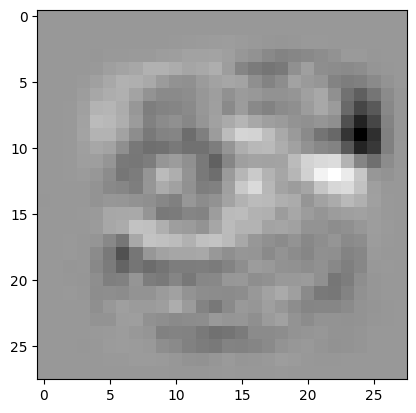

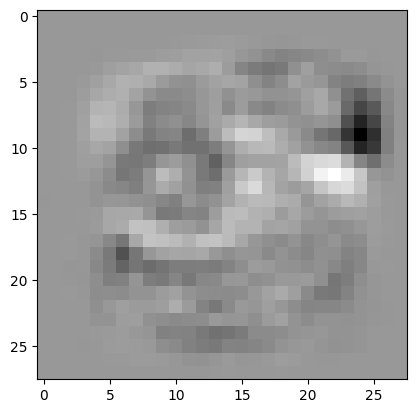

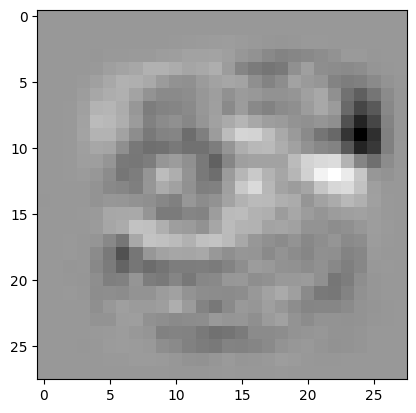

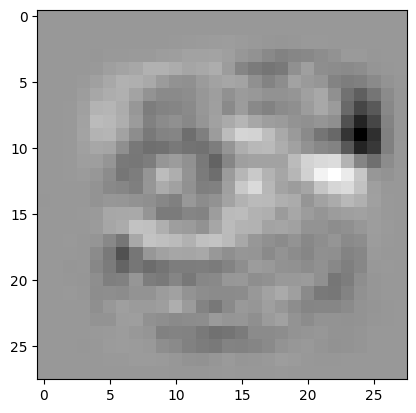

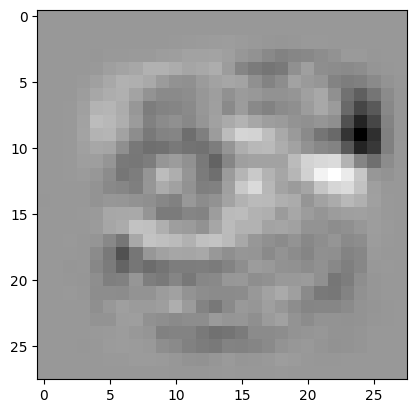

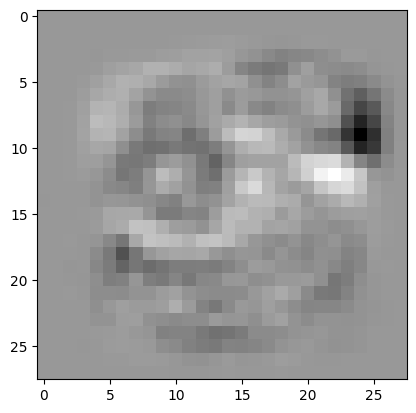

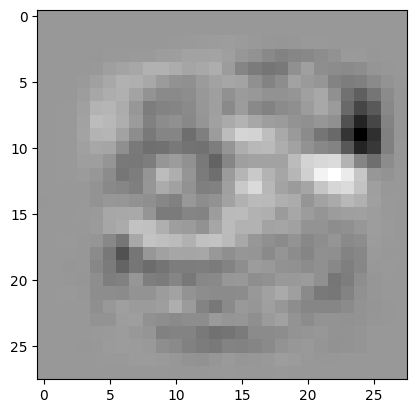

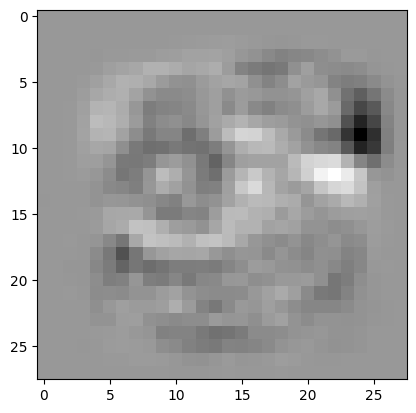

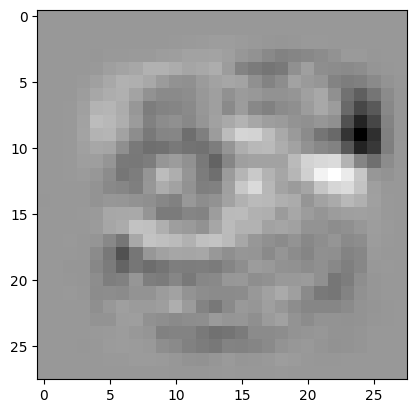

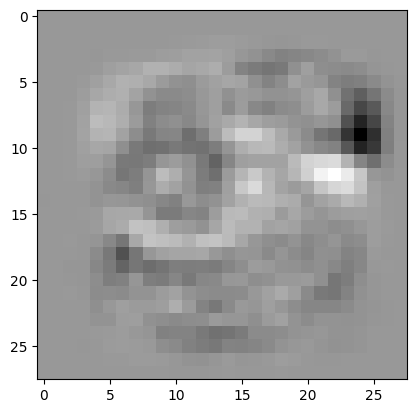

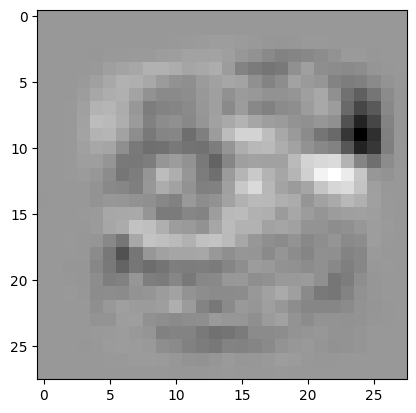

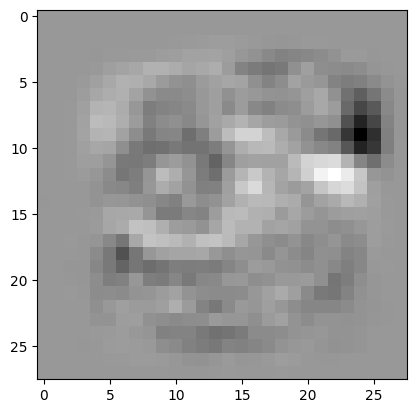

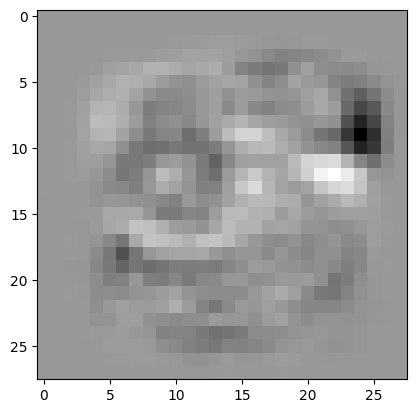

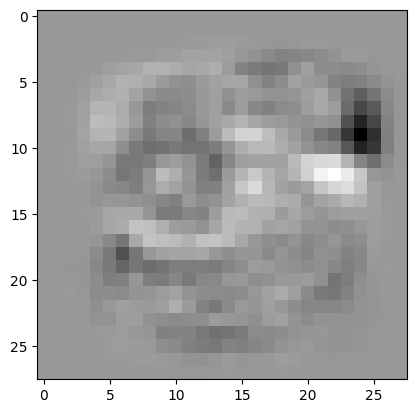

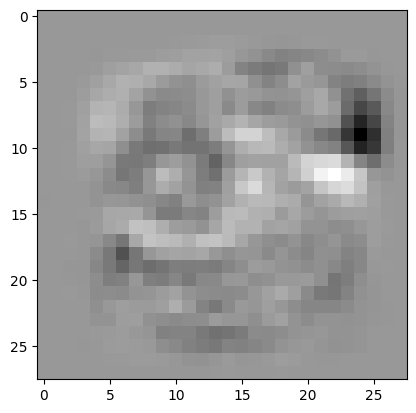

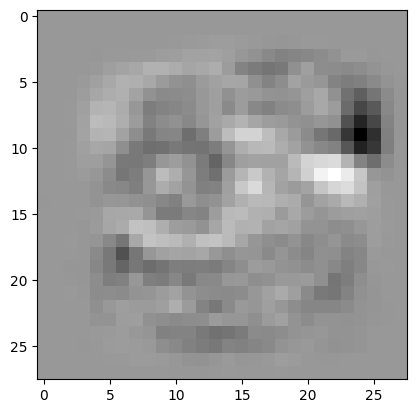

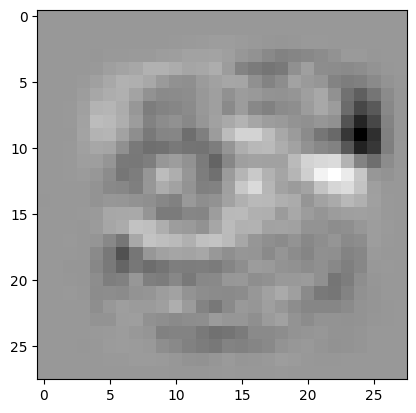

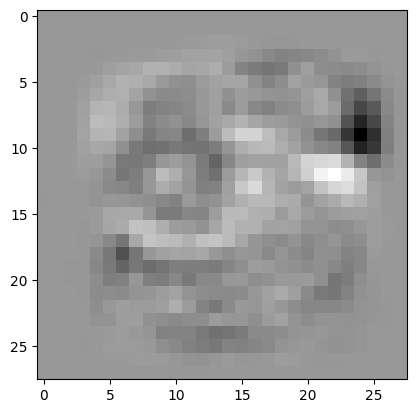

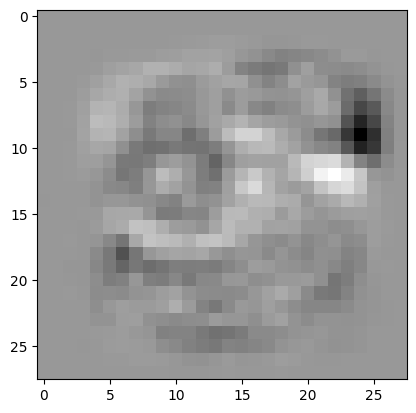

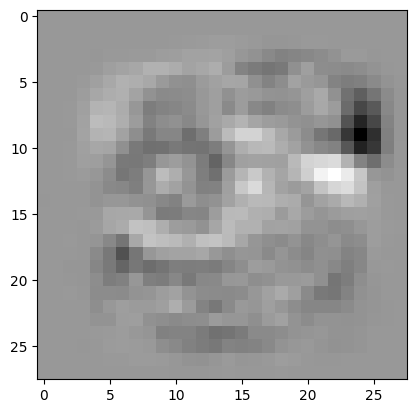

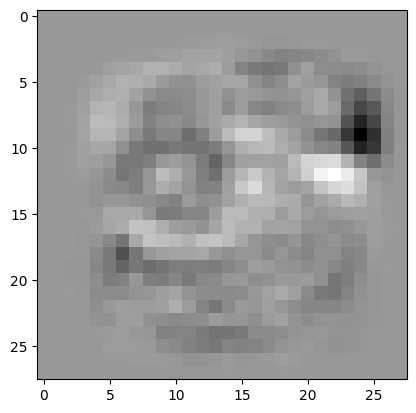

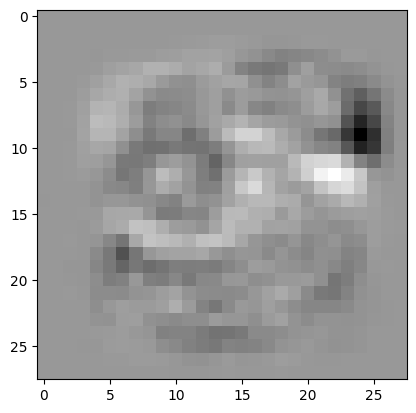

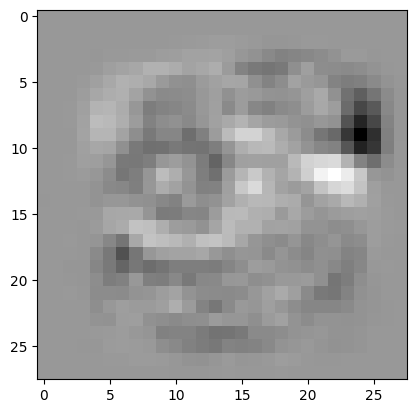

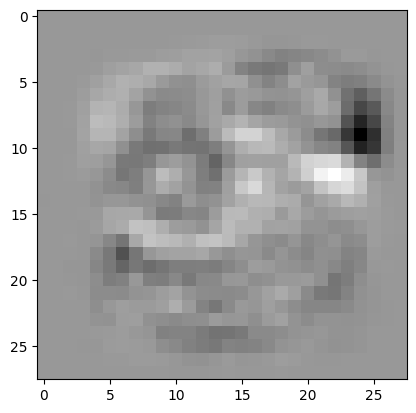

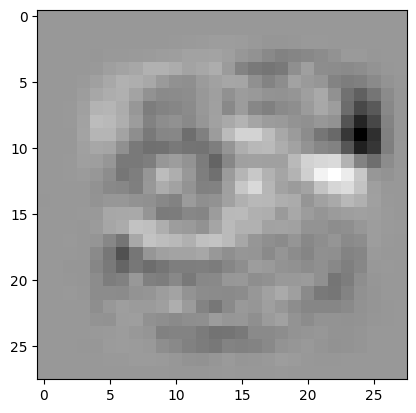

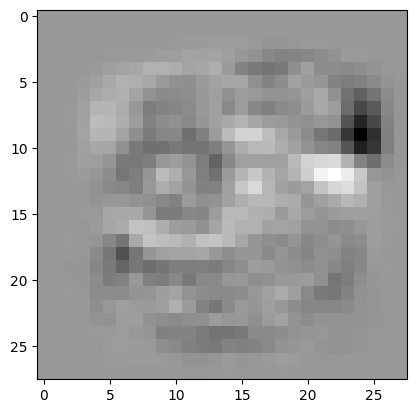

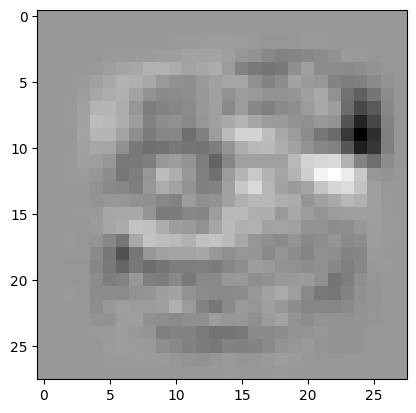

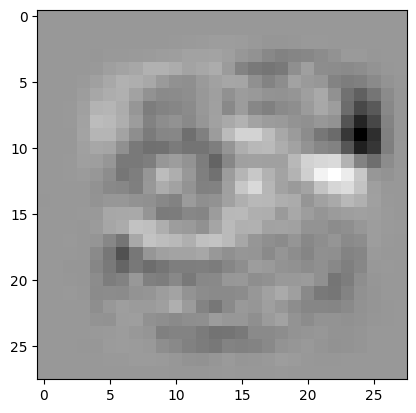

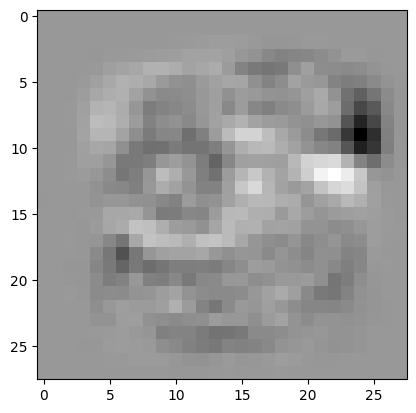

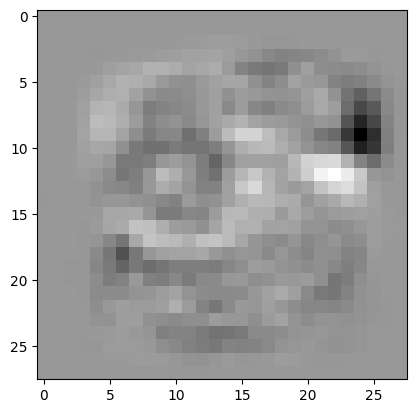

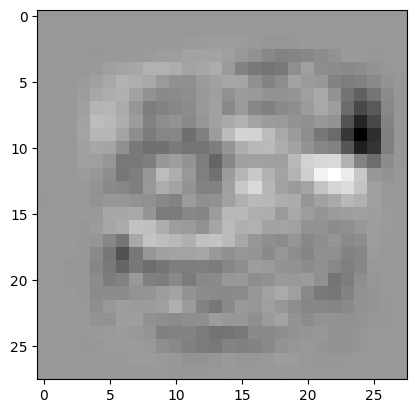

In [54]:
# resposta 1

import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy()) # Não entendi porque outputs[1]

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()

    # Imprimir os gradientes
    #print(f"\nÉpoca {i+1}")
    for name, param in model.named_parameters():
        if name == 'weight':
          if param.requires_grad:
            # OBs: Vi que na solução mostra o valor dos pesos, mas aqui pedia o gradiente!
            #
            #print(f"Época {i+1} - Gradiente pra o dígito 4 (shape: {param.grad[5].shape}):")
            #print(param.grad[5])
            plt.imshow(param.grad[5].numpy().reshape((28,28)),cmap = 'gray')
            plt.show()

    optimizer.step()


    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

In [55]:
# Respostas
# 1) [60000, 784]
# 2) [60000, 10]
# 3) (784 * 10) + 10 = 7850

# Aprendizados
